<a href="https://colab.research.google.com/github/slp22/deep-learning-project/blob/main/dl_diabetic_retinopathy_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Deep Learning | MVP

# Diabetic Retinopathy<a id='top'></a> 

## **Analysis Goal**  
The client, the [National Eye Institute](https://www.nei.nih.gov/), part of the National Institutes of Health, wants a model that can quickly identify [diabetic retinopathy](https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy) in patients participating in early phase clinical trials.

**RQ:** How well can a neural network diagnose diabetic retinopathy from a retinal image?


## **Process**
**Data source:** Retinal images at various stages of [Diabetic Retinopathy](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized) n=35,126 resized into 224x224 pixels

0 - No_DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferate_DR
...

**Models:** 
...


## **Preliminary Conclusions**
...


In [1]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import PIL
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import warnings

%pylab inline
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']  # or svg
pd.set_option('display.max_colwidth', None)
sns.set(context='notebook', style='whitegrid')
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing import image as IMG
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.models import Sequential
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras Version:", tf.keras.__version__)
print("Scikit-learn version:", sk.__version__)


Populating the interactive namespace from numpy and matplotlib
Matplotlib version: 3.2.2
Numpy version: 1.21.6
Pandas version: 1.3.5
TensorFlow version: 2.8.2
Keras Version: 2.8.0
Scikit-learn version: 1.0.2


## 1 | Dataset: [Diabetic Retinopathy Retinal Images](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)<a id='1'></a>  

Code adapted from [github/PurpleGrace](https://github.com/PurpleGrace/Deep_Learning_Tools_Image_Classification/blob/main/code/1.EDA_Sample_Images.ipynb)


In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandralparedes","key":"52716e458c895e3e9d7fcfde80b0d59e"}'}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! pwd
! ls

/content
drive  kaggle.json  sample_data


In [7]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [8]:
! kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

 99% 1.92G/1.94G [00:27<00:00, 83.8MB/s]
100% 1.94G/1.94G [00:27<00:00, 74.7MB/s]


In [9]:
zip_ref = zipfile.ZipFile('diabetic-retinopathy-2015-data-colored-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [10]:
print('Mild:', len(os.listdir('/tmp/colored_images/colored_images/Mild')))
print('Moderate:', len(os.listdir('/tmp/colored_images/colored_images/Moderate')))
print('No_DR:', len(os.listdir('/tmp/colored_images/colored_images/No_DR')))
print('Proliferate_DR:', len(os.listdir('/tmp/colored_images/colored_images/Proliferate_DR')))
print('Severe:', len(os.listdir('/tmp/colored_images/colored_images/Severe')))



Mild: 2443
Moderate: 5292
No_DR: 25810
Proliferate_DR: 708
Severe: 873


In [34]:
# read in files and store as dataframe
filepath = '/tmp/colored_images/colored_images'
dataframe = {'image_path':[],'diagnosis':[]}
print("List of diagnoses:")
for diagnosis in os.listdir(filepath):
    print(diagnosis)
    if diagnosis != 'Dataset':        
        for image in os.listdir(filepath +"/"+diagnosis):
            if image != 'Dataset':
                data['image_path'].append(filepath +"/"+diagnosis+"/"+ image)
                data['diagnosis'].append(diagnosis)
dataframe = pd.DataFrame(data)  

print('Datatype:',type(dataframe))  
dataframe.head()


List of diagnoses:
Moderate


TypeError: ignored

## 2 | Exploratory Data Analysis<a id='2'></a>  

In [13]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  35126 non-null  object
 1   diagnosis   35126 non-null  object
dtypes: object(2)
memory usage: 549.0+ KB


n = 35,126

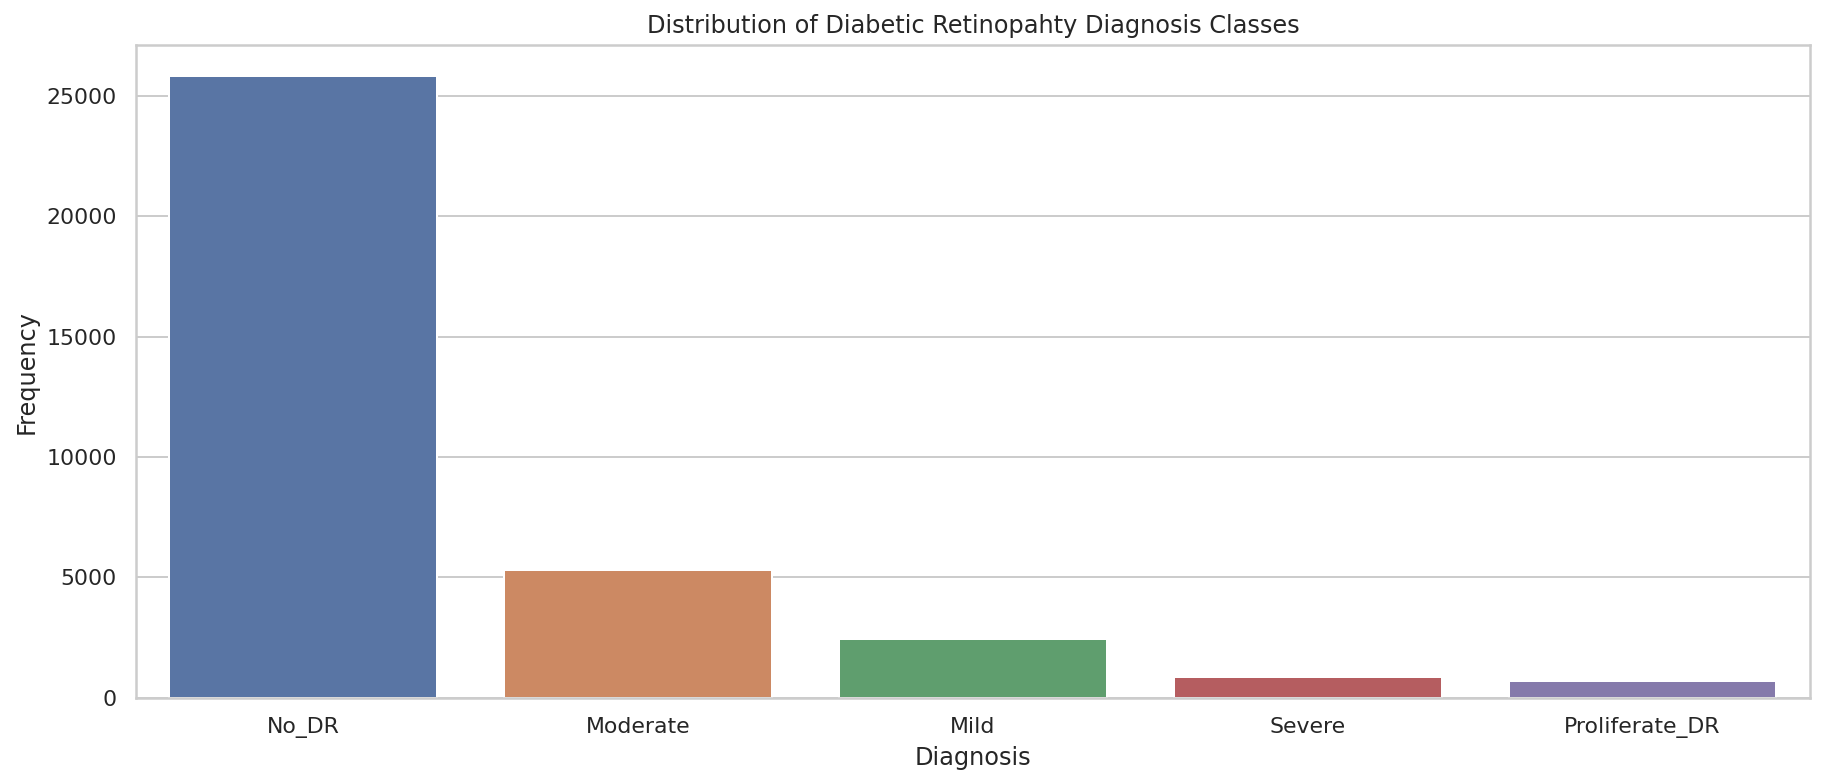

In [14]:
# distribution of diagnosis classes
plt.figure(figsize=(15,6))
sns.barplot(data.diagnosis.value_counts().index,
            dataframe.diagnosis.value_counts(),
            palette=None)
plt.title("Distribution of Diabetic Retinopahty Diagnosis Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Frequency");


Unbalanced classes

No Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


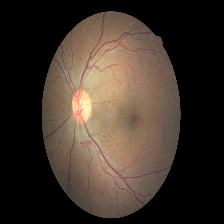

In [18]:
# show one healthy image

path = '/tmp/colored_images/colored_images/No_DR/10003_left.png'

healthy_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256),
   interpolation="nearest")
print('No Diabetic Retinopthy')
print('Datatype:', type(healthy_image))
healthy_image 


Severe Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


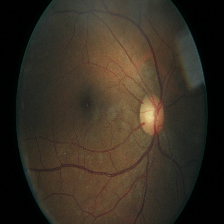

In [21]:
# show one severe DR image

path = '/tmp/colored_images/colored_images/Severe/1002_left.png'

severe_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256), 
   interpolation="nearest")

print('Severe Diabetic Retinopthy')
print('Datatype:', type(severe_image))
severe_image 


### Preprocessing<a id='tp'></a>  

In [22]:
# read in all images as a tensor BatchDataset
# https://keras.io/api/preprocessing/image/

directory = '/tmp/colored_images/colored_images'
databatch = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False )

print('Datatype:', type(databatch), '\n')
databatch

Found 35126 files belonging to 5 classes.
Datatype: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 



<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
class_names = databatch.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [24]:
for image_batch, labels_batch in databatch:
  print('image_batch.shape', image_batch.shape)
  print('labels_batch.shape', labels_batch.shape)
  break

image_batch.shape (32, 256, 256, 3)
labels_batch.shape (32,)


image_batch = tensor 32 images, sized 256x256, 3 RBG colors

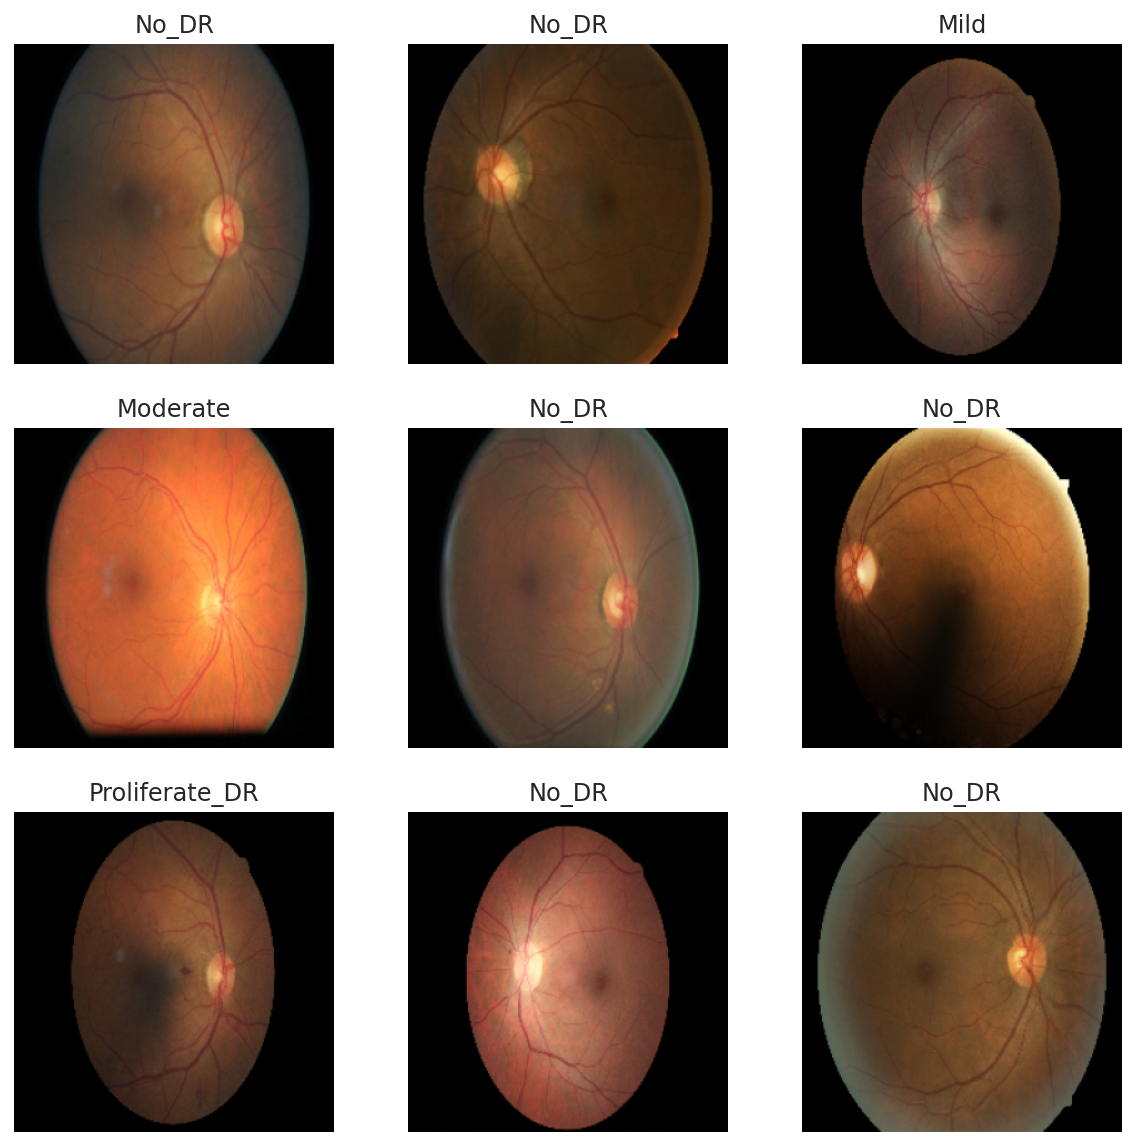

In [28]:
# show a sample of each diagnosis 

plt.figure(figsize=(10, 10))
for images, labels in databatch.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [32]:
# https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/op/data/BatchDataset

# convert healthy_image to numpy array

img = healthy_image
healthy_image_array = tf.keras.preprocessing.image.img_to_array(img, 
                                                                data_format=None, 
                                                                dtype=None)
print('Healthy Image Array')
print('type:', type(healthy_image_array))
healthy_image_array

Healthy Image Array
type: <class 'numpy.ndarray'>


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [33]:
# https://www.tensorflow.org/jvm/api_docs/java/org/tensorflow/op/data/BatchDataset

# convert all images to numpy array

all_image_array = tf.keras.preprocessing.image.img_to_array(dataframe, 
                                                                data_format=None, 
                                                                dtype=None)
print('All Images Array')
print('type:', type(healthy_image_array))
all_image_array

TypeError: ignored

https://www.h5py.org/
https://www.tensorflow.org/tutorials/images/cnn
https://www.tensorflow.org/tutorials/images/classification
https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb#scrollTo=pb2Af2lsUShk

data = '/content/drive/MyDrive/Dataset'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(256, 256),
  batch_size=32)


Found 11800 files belonging to 5 classes.
Using 9440 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(256, 256),
  batch_size=32)


Found 11800 files belonging to 5 classes.
Using 2360 files for validation.


## 3 | Baseline Model<a id='3'></a>  

Look at https://github.com/ngoodby/Metis-Deep-Learning-Project/blob/master/model_creation.ipynb

## 4 | Deep Learning Model<a id='4'></a>  

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
295/295 [==============================] - 455s 1s/step - loss: 1.1690 - accuracy: 0.4988 - val_loss: 1.1385 - val_accuracy: 0.5136
Epoch 2/10
162/295 [===============>..............] - ETA: 2:28 - loss: 1.1367 - accuracy: 0.5110

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5 | Transfer Learning Model<a id='5'></a>  